In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', -1)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import spacy
import re
import string
from textblob import TextBlob
import seaborn as sns
plt.style.use('ggplot')
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

In [0]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

In [0]:
from datetime import datetime
from gensim.models import word2vec

In [0]:
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim


In [0]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['br', 'ive', 'gery', 'one', 'product']) #<<- keep updating stop_words if there are unneccessary words whenever checking text 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
from google.colab import files
from io import BytesIO
from PIL import Image

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/capstone3/data/doc_train.csv')

In [0]:
df.head(1)

,Unnamed: 0,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,token_words,join_token,Date,year,words_count,unique_words,new_token_words,data_lemmatized,polarity,subjectivity,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,doc2vec_vector_5,doc2vec_vector_6,doc2vec_vector_7,doc2vec_vector_8,doc2vec_vector_9
0,491450,491451,B005A1LH0Q,A2Z3EDGYBA75F5,Jeanne R. Michon,2,2,4,1322611200,Great snack,"I was pleasantly surprised at these little snacks. Thought sure they wouldn't fill me up, but they did. Had just the right amount of crunch and a hint of cinnamon flavor that was not overpowering or bitter.",i was pleasantly surprised at these little snacks thought sure they wouldnt fill me up but they did had just the right amount of crunch and a hint of cinnamon flavor that was not overpowering or bitter,"['pleasantli', 'surpris', 'littl', 'snack', 'thought', 'sure', 'wouldnt', 'fill', 'right', 'amount', 'crunch', 'hint', 'cinnamon', 'flavor', 'overpow', 'bitter']",pleasantli surpris littl snack thought sure wouldnt fill right amount crunch hint cinnamon flavor overpow bitter,2011-11-30,2011,37,16,pleasantli surpris littl snack thought sure wouldnt fill right amount crunch hint cinnamon flavor overpow bitter,"['snack', 'amount', 'crunch', 'hint', 'cinnamon', 'flavor']",0.119643,0.664921,-0.093459,0.010824,0.044514,0.019727,-0.061364,0.016364,-0.032123,0.031593,0.025646,0.013055


# New Section

In [0]:
df.columns

Index(['Unnamed: 0', 'Id', 'ProductId', 'UserId', 'ProfileName',
       'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time',
       'Summary', 'Text', 'clean_text', 'token_words', 'join_token', 'Date',
       'year', 'words_count', 'unique_words', 'new_token_words',
       'data_lemmatized', 'polarity', 'subjectivity', 'doc2vec_vector_0',
       'doc2vec_vector_1', 'doc2vec_vector_2', 'doc2vec_vector_3',
       'doc2vec_vector_4', 'doc2vec_vector_5', 'doc2vec_vector_6',
       'doc2vec_vector_7', 'doc2vec_vector_8', 'doc2vec_vector_9'],
      dtype='object')

In [0]:
data = df.clean_text.values.tolist()

pprint(data[:1])

['i was pleasantly surprised at these little snacks  thought sure they wouldnt '
 'fill me up but they did  had just the right amount of crunch and a hint of '
 'cinnamon flavor that was not overpowering or bitter']


In [0]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['was', 'pleasantly', 'surprised', 'at', 'these', 'little', 'snacks', 'thought', 'sure', 'they', 'wouldnt', 'fill', 'me', 'up', 'but', 'they', 'did', 'had', 'just', 'the', 'right', 'amount', 'of', 'crunch', 'and', 'hint', 'of', 'cinnamon', 'flavor', 'that', 'was', 'not', 'overpowering', 'or', 'bitter']]


In [0]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['was', 'pleasantly_surprised', 'at', 'these', 'little', 'snacks', 'thought', 'sure', 'they', 'wouldnt', 'fill', 'me', 'up', 'but', 'they', 'did', 'had', 'just', 'the', 'right', 'amount', 'of', 'crunch', 'and', 'hint', 'of', 'cinnamon', 'flavor', 'that', 'was', 'not', 'overpowering', 'or', 'bitter']


In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [0]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en', disable=['parser', 'ner'])

In [0]:
start = datetime.now()
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])
end = datetime.now()
print('Duration:{}'.format(end-start))
print(data_lemmatized[:1])

Duration:0:16:34.928726
[['snack', 'amount', 'crunch', 'hint', 'cinnamon', 'flavor']]


In [0]:
with open('/content/drive/My Drive/capstone3/data_lemmatized.txt', 'w') as file_handler:
    for item in data_lemmatized:
        file_handler.write("{}\n".format(item))

In [0]:
df['data_lemmatized'] = np.array(data_lemmatized)

In [0]:
df['data_lemmatized'].iloc[:10]

0    [snack, amount, crunch, hint, cinnamon, flavor]                                                                                                                                                                                                                                                                                                                                                                                      
1    [coffee, product, cup, price]                                                                                                                                                                                                                                                                                                                                                                                                        
2    [item, bulldog, stuff, price, shipping, recommend, dog, lover, dog, treat]                                                                   

In [0]:
dct = corpora.Dictionary(simple_preprocess(line, deacc=True) for line in open('/content/drive/My Drive/capstone3/clean_text.txt'))

In [0]:
start = datetime.now()
corpus = [dct.doc2bow(line) for line in np.array(data_lemmatized)]
end = datetime.now()
print('Duaration: {}'.format(end-start))

Duaration: 0:00:05.932671


In [0]:
import pickle
pickle.dump(corpus, open('/content/drive/My Drive/capstone3/corpus.pkl', 'wb'))
dct.save('/content/drive/My Drive/capstone3/dct.gensim')

In [0]:
dct = corpora.Dictionary.load('/content/drive/My Drive/capstone3/dct.gensim')
corpus = pickle.load(open('/content/drive/My Drive/capstone3/data/corpus.pkl', 'rb'))

start = datetime.now()
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df['data_lemmatized'])]
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=200, window=7, min_count=5, workers=4)
model.save('/content/drive/My Drive/capstone3/doc2vec.model')
# transform each document into a vector data
doc2vec_df = df["data_lemmatized"].apply(lambda x: model.infer_vector(x)).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_" + str(x) for x in doc2vec_df.columns]

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
documents[:30]

[TaggedDocument(words="['snack', 'amount', 'crunch', 'hint', 'cinnamon', 'flavor']", tags=[0]),
 TaggedDocument(words="['coffee', 'product', 'cup', 'price']", tags=[1]),
 TaggedDocument(words="['item', 'bulldog', 'stuff', 'price', 'shipping', 'recommend', 'dog', 'lover', 'dog', 'treat']", tags=[2]),
 TaggedDocument(words="['catnipmist', 'couple', 'review', 'cost', 'field', 'oil', 'rejuvenator', 'truebr', 'smartykat', 'catnipmist', 'cat', 'walked_away', 'field', 'oil', 'rejuvenator', 'cat', 'sniff', 'roll', 'wrestle', 'downside', 'star', 'star', 'field', 'pay', 'forbr', 'cat', 'cost', 'cat', 'stick', 'field', 'oil', 'rejuvenator']", tags=[3]),
 TaggedDocument(words="['let', 'water', 'bottle', 'amazon', 'account', 'review', 'term', 'money', 'idea', 'prop']", tags=[4]),
 TaggedDocument(words="['world', 'soup', 'product', 'wolf_gang', 'puck', 'line', 'chunkys', 'world', 'reminder', 'society', 'selfview', 'gender', 'hegemony', 'imagine', 'puck', 'realm', 'home', 'cookinbr', 'disappointment'

**Doc2Vec - used for clustering in clustering juypter notebook**


In [0]:
doc2vec_df.to_pickle('/content/drive/My Drive/capstone3/doc2vec_df.pkl')
doc2vec_df

,doc2vec_0,doc2vec_1,doc2vec_2,doc2vec_3,doc2vec_4,doc2vec_5,doc2vec_6,doc2vec_7,doc2vec_8,doc2vec_9,doc2vec_10,doc2vec_11,doc2vec_12,doc2vec_13,doc2vec_14,doc2vec_15,doc2vec_16,doc2vec_17,doc2vec_18,doc2vec_19,doc2vec_20,doc2vec_21,doc2vec_22,doc2vec_23,doc2vec_24,doc2vec_25,doc2vec_26,doc2vec_27,doc2vec_28,doc2vec_29,doc2vec_30,doc2vec_31,doc2vec_32,doc2vec_33,doc2vec_34,doc2vec_35,doc2vec_36,doc2vec_37,doc2vec_38,doc2vec_39,...,doc2vec_160,doc2vec_161,doc2vec_162,doc2vec_163,doc2vec_164,doc2vec_165,doc2vec_166,doc2vec_167,doc2vec_168,doc2vec_169,doc2vec_170,doc2vec_171,doc2vec_172,doc2vec_173,doc2vec_174,doc2vec_175,doc2vec_176,doc2vec_177,doc2vec_178,doc2vec_179,doc2vec_180,doc2vec_181,doc2vec_182,doc2vec_183,doc2vec_184,doc2vec_185,doc2vec_186,doc2vec_187,doc2vec_188,doc2vec_189,doc2vec_190,doc2vec_191,doc2vec_192,doc2vec_193,doc2vec_194,doc2vec_195,doc2vec_196,doc2vec_197,doc2vec_198,doc2vec_199
0,0.017688,-0.066032,-0.032917,0.021086,0.017136,0.047369,0.035270,0.000432,0.007202,0.002777,-0.003404,-0.003137,-0.008978,-0.002421,-0.025434,-0.001608,-0.019240,0.008869,-0.048088,0.012533,-0.014105,-0.011365,-0.010902,-0.009515,-0.042178,-0.005578,-0.017870,-0.019605,-0.022553,-0.005077,-0.003625,0.007640,-0.015481,0.006517,0.012947,-0.006896,0.018816,-0.000142,-0.005011,-0.015399,...,0.025751,0.022786,0.016859,-0.005655,0.000924,0.024440,0.031404,0.002658,-0.035432,0.001441,-0.008827,0.013730,-0.000790,0.008637,-0.007868,-0.022497,-0.015382,0.013986,-0.018191,0.007919,0.025239,-0.009735,0.013936,-0.007556,-0.000623,0.013646,0.021190,0.004085,0.009499,0.007812,0.011106,0.015120,-0.001252,0.002764,-0.007921,0.002384,0.003728,-0.009538,-0.020891,0.008254
1,0.014932,-0.041262,-0.041342,0.002035,0.016909,0.043571,0.019211,-0.009784,-0.013866,-0.005963,-0.025331,0.001743,-0.028342,-0.003208,-0.024192,-0.006123,-0.008066,0.023680,-0.038551,-0.014760,-0.019905,0.009940,-0.031898,-0.029591,-0.014116,0.017216,-0.004447,-0.051823,-0.000723,-0.015810,-0.023572,0.031887,-0.017086,-0.010271,0.010990,0.006231,0.005796,0.008976,0.007824,-0.012509,...,0.019408,0.016353,0.009106,-0.007781,-0.000652,0.038784,0.027965,-0.008994,-0.025926,0.003128,-0.010727,0.004518,0.008499,0.008281,-0.002171,-0.044895,-0.015514,0.013830,-0.010629,0.017869,0.021401,-0.016577,0.024042,-0.009694,-0.007739,0.015027,0.026485,0.005593,-0.001872,0.003644,0.026329,0.001076,0.000435,0.001556,0.003323,0.000758,0.010245,-0.007771,-0.013504,-0.014266
2,0.008347,-0.025935,-0.039618,0.007406,0.014831,0.017109,0.009522,-0.001138,0.007893,0.000455,0.001425,-0.020699,-0.011112,-0.003527,-0.014857,0.005768,-0.008229,-0.015113,-0.025653,-0.009213,0.008478,-0.003216,-0.020891,-0.019089,-0.012364,0.024004,-0.010693,-0.032366,-0.010533,-0.013641,-0.015436,0.022892,-0.014017,0.015919,-0.002439,0.000689,0.007006,-0.010440,-0.003707,-0.015768,...,0.012428,0.016211,0.011173,-0.013934,-0.014206,0.015683,0.002425,-0.004228,-0.024787,-0.006630,0.000710,0.003393,0.000534,0.001911,-0.009725,-0.025614,-0.000765,0.012299,0.003115,0.003721,0.012548,0.007339,-0.000759,-0.001369,-0.010190,0.022256,-0.000353,0.006862,0.014646,0.024742,0.006518,0.011308,-0.003739,-0.003708,0.003887,0.010972,-0.000710,-0.003336,-0.007643,0.002128
3,0.045139,-0.050753,-0.025572,0.014936,0.012436,0.013532,0.038051,0.001758,-0.050699,0.015712,-0.044860,0.015251,-0.054470,0.006249,-0.020835,-0.028086,-0.004026,0.078416,-0.009993,-0.055365,-0.048316,0.060279,-0.046147,-0.038926,0.030561,0.054264,0.061735,-0.100193,0.041984,-0.003902,-0.040704,0.030621,-0.045796,-0.066450,0.013673,-0.015073,0.006380,0.013463,0.031357,-0.010117,...,-0.012184,0.021556,0.009355,-0.000852,-0.002902,0.020054,0.039177,-0.026819,-0.017754,0.016183,-0.028102,-0.011320,0.027381,-0.003618,0.023181,-0.038870,0.008970,0.024811,0.017487,0.032586,0.026290,-0.012522,0.005409,0.007539,-0.018804,-0.011311,0.000919,-0.009340,-0.028596,0.016225,0.027792,-0.001618,-0.020136,-0.002925,-0.022485,-0.014390,0.037980,0.045401,-0.012261,-0.008005
4,0.008855,-0.06

In [0]:
from gensim.models import LdaModel, LdaMulticore


# Clustering 4
model_4 = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=4,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

In [0]:
model_4.save('/content/drive/My Drive/capstone3/model_4.model')

df_4 = pd.DataFrame(model_4.print_topics(-1))
df_4

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,0,1
0,0,"0.020*""flavor"" + 0.019*""taste"" + 0.015*""amazon"" + 0.014*""chocolate"" + 0.012*""price"" + 0.012*""store"" + 0.012*""box"" + 0.012*""love"" + 0.011*""time"" + 0.011*""bag"""
1,1,"0.096*""coffee"" + 0.029*""flavor"" + 0.029*""cup"" + 0.020*""taste"" + 0.014*""sauce"" + 0.013*""kcup"" + 0.010*""bean"" + 0.010*""love"" + 0.009*""time"" + 0.009*""blend"""
2,2,"0.066*""food"" + 0.050*""dog"" + 0.026*""cat"" + 0.025*""treat"" + 0.012*""time"" + 0.011*""day"" + 0.010*""year"" + 0.008*""chicken"" + 0.008*""baby"" + 0.008*""month"""
3,3,"0.095*""tea"" + 0.039*""water"" + 0.027*""taste"" + 0.027*""flavor"" + 0.022*""drink"" + 0.021*""bottle"" + 0.010*""sugar"" + 0.010*""day"" + 0.010*""energy"" + 0.009*""time"""


In [0]:
start_time = datetime.now()

# Clustering 5
model_5 = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=5,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
# save the model
model_5.save('/content/drive/My Drive/capstone3/model_5.model')
end_time = datetime.now()
print('Duration: {}.format(end_time -start_time)')
df_5 = pd.DataFrame(model_5.print_topics(-1))
df_5

In [0]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(model_5[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
    
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

start_time = datetime.now()
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 5

end_time = datetime.now()
print('Duration: {}'.format(end_time -start_time))

Duration: 0:23:50.322466


In [0]:
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(5), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
plt.savefig('/content/drive/My Drive/capstone3/amazon_review_analysis/Topic_modelling/5_cluster.png')


Saving 5_cluster.png to 5_cluster (3).png


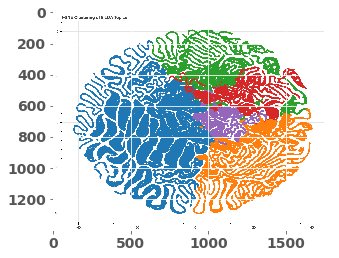

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['5_cluster.png']))

plt.imshow(im)
plt.show()

In [0]:
start_time = datetime.now()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_5, corpus, dictionary=model_5.id2word)
end_time = datetime.now()
print('Duration: {}'.format(end_time -start_time))
pyLDAvis.save_html(vis, '/content/drive/My Drive/capstone3/5_topmodelling.html')
vis

Duration: 0:52:04.841795


/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.079999  0.036134  1       1        35.325115
2      0.247513  0.037468  2       1        21.752502
4     -0.039613 -0.238630  3       1        17.406616
1     -0.130848  0.164122  4       1        16.382849
3     -0.157052  0.000907  5       1        9.132912 , topic_info=    Category          Freq     Term         Total  loglift  logprob
6    Default  82068.000000  coffee   82068.000000  30.0000  30.0000
105  Default  59567.000000  tea      59567.000000  29.0000  29.0000
66   Default  64430.000000  food     64430.000000  28.0000  28.0000
11   Default  49127.000000  dog      49127.000000  27.0000  27.0000
7    Default  30473.000000  cup      30473.000000  26.0000  26.0000
..       ...           ...  ...               ...      ...      ...
127  Topic5   1935.153320   way      21041.136719  0.0070  -5.2993 
253  Topic5   1932.180298   sugar    21524.625000 -0.0173  -5.3008 
163  Topic5   1893.344360   use      20456.458984  0.0133  -5.3211 
480  Topic5   1655.261597   quality  15206.500000  0.1755  -5.4555 
117  Topic5   1517.946045   lot      18591.855469 -0.1121  -5.5421 

[335 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1482  3      0.998682  alcohol
38    1      0.893421  amazon 
38    2      0.054831  amazon 
38    4      0.051758  amazon 
214   1      0.249909  apple  
...  ..           ...     ... 
164   5      0.057430  year   
5995  5      0.997725  yogi   
1050  1      0.003357  yogurt 
1050  3      0.996568  yogurt 
3178  3      0.998441  zico   

[492 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 5, 2, 4])

In [0]:
start_time = datetime.now()

# Clustering 6
model_6 = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=6,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
# save the model
model_6.save('/content/drive/My Drive/capstone3/model_6.model')
end_time = datetime.now()
print('Duration: {}.format(end_time -start_time)')
df_6 = pd.DataFrame(model_6.print_topics(-1))
df_6

Duration: {}.format(end_time -start_time)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,0,1
0,0,"0.033*""amazon"" + 0.028*""price"" + 0.026*""store"" + 0.023*""box"" + 0.018*""time"" + 0.017*""bag"" + 0.015*""order"" + 0.013*""cookie"" + 0.012*""love"" + 0.011*""year"""
1,1,"0.030*""flavor"" + 0.020*""taste"" + 0.019*""chip"" + 0.018*""sauce"" + 0.017*""salt"" + 0.010*""rice"" + 0.009*""bag"" + 0.009*""use"" + 0.009*""time"" + 0.009*""love"""
2,2,"0.067*""food"" + 0.058*""dog"" + 0.030*""cat"" + 0.026*""treat"" + 0.013*""day"" + 0.012*""time"" + 0.010*""year"" + 0.009*""baby"" + 0.008*""month"" + 0.008*""ingredient"""
3,3,"0.048*""water"" + 0.036*""taste"" + 0.033*""flavor"" + 0.026*""bottle"" + 0.023*""drink"" + 0.019*""coconut"" + 0.013*""milk"" + 0.012*""sugar"" + 0.011*""oil"" + 0.010*""use"""
4,4,"0.044*""chocolate"" + 0.037*""bar"" + 0.029*""sugar"" + 0.028*""taste"" + 0.026*""snack"" + 0.025*""flavor"" + 0.018*""calorie"" + 0.018*""cereal"" + 0.017*""protein"" + 0.013*""fruit"""
5,5,"0.120*""coffee"" + 0.082*""tea"" + 0.040*""cup"" + 0.031*""flavor"" + 0.023*""taste"" + 0.016*""kcup"" + 0.012*""love"" + 0.011*""blend"" + 0.010*""bag"" + 0.010*""pod"""


In [0]:
start_time = datetime.now()

# Clustering 7
model_7 = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=7,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
# save the model
model_7.save('/content/drive/My Drive/capstone3/model_7.model')
end_time = datetime.now()
print('Duration: {}.format(end_time -start_time)')
df_7 = pd.DataFrame(model_7.print_topics(-1))
df_7

Duration: {}.format(end_time -start_time)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,0,1
0,0,"0.036*""amazon"" + 0.032*""price"" + 0.028*""store"" + 0.024*""box"" + 0.018*""time"" + 0.018*""bag"" + 0.016*""order"" + 0.012*""love"" + 0.011*""year"" + 0.011*""item"""
1,1,"0.032*""flavor"" + 0.021*""taste"" + 0.020*""chip"" + 0.018*""sauce"" + 0.018*""salt"" + 0.010*""rice"" + 0.010*""bag"" + 0.009*""love"" + 0.009*""food"" + 0.009*""cheese"""
2,2,"0.071*""food"" + 0.059*""dog"" + 0.031*""cat"" + 0.027*""treat"" + 0.013*""day"" + 0.012*""time"" + 0.010*""year"" + 0.009*""baby"" + 0.009*""ingredient"" + 0.008*""month"""
3,3,"0.063*""water"" + 0.030*""taste"" + 0.030*""bottle"" + 0.025*""flavor"" + 0.023*""drink"" + 0.022*""coconut"" + 0.017*""oil"" + 0.014*""milk"" + 0.013*""use"" + 0.011*""powder"""
4,4,"0.046*""chocolate"" + 0.032*""bar"" + 0.030*""taste"" + 0.030*""sugar"" + 0.029*""flavor"" + 0.022*""snack"" + 0.021*""cookie"" + 0.016*""calorie"" + 0.016*""cereal"" + 0.014*""protein"""
5,5,"0.152*""coffee"" + 0.045*""cup"" + 0.029*""flavor"" + 0.021*""taste"" + 0.020*""kcup"" + 0.013*""blend"" + 0.012*""pod"" + 0.011*""bean"" + 0.010*""love"" + 0.010*""roast"""
6,6,"0.215*""tea"" + 0.035*""flavor"" + 0.028*""taste"" + 0.020*""bag"" + 0.017*""honey"" + 0.016*""ginger"" + 0.015*""love"" + 0.014*""cup"" + 0.010*""day"" + 0.010*""time"""


In [0]:
start_time = datetime.now()

# Clustering 8
model_8 = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=8,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
# save the model
model_8.save('/content/drive/My Drive/capstone3/model_8.model')
end_time = datetime.now()
print('Duration: {}'.format(end_time -start_time))
df_8 = pd.DataFrame(model_8.print_topics(-1))
df_8

Duration: 0:09:52.389448


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,0,1
0,0,"0.038*""amazon"" + 0.034*""price"" + 0.030*""store"" + 0.026*""box"" + 0.019*""bag"" + 0.019*""time"" + 0.017*""order"" + 0.013*""love"" + 0.011*""item"" + 0.011*""package"""
1,1,"0.034*""flavor"" + 0.021*""taste"" + 0.021*""chip"" + 0.020*""sauce"" + 0.019*""salt"" + 0.011*""food"" + 0.011*""rice"" + 0.011*""love"" + 0.010*""bag"" + 0.009*""cheese"""
2,2,"0.034*""water"" + 0.017*""bottle"" + 0.016*""day"" + 0.016*""oil"" + 0.015*""coconut"" + 0.014*""taste"" + 0.013*""baby"" + 0.012*""time"" + 0.011*""hair"" + 0.010*""use"""
3,3,"0.041*""mix"" + 0.038*""flavor"" + 0.024*""powder"" + 0.023*""water"" + 0.021*""juice"" + 0.019*""drink"" + 0.016*""fruit"" + 0.015*""packet"" + 0.015*""taste"" + 0.015*""cake"""
4,4,"0.047*""chocolate"" + 0.034*""sugar"" + 0.033*""taste"" + 0.032*""bar"" + 0.029*""flavor"" + 0.020*""snack"" + 0.017*""cookie"" + 0.017*""calorie"" + 0.016*""cereal"" + 0.015*""milk"""
5,5,"0.155*""coffee"" + 0.048*""cup"" + 0.030*""flavor"" + 0.023*""taste"" + 0.021*""kcup"" + 0.013*""blend"" + 0.013*""pod"" + 0.012*""bean"" + 0.010*""roast"" + 0.010*""love"""
6,6,"0.217*""tea"" + 0.042*""flavor"" + 0.031*""taste"" + 0.021*""bag"" + 0.017*""honey"" + 0.017*""love"" + 0.016*""ginger"" + 0.015*""cup"" + 0.011*""drink"" + 0.010*""time"""
7,7,"0.089*""food"" + 0.084*""dog"" + 0.044*""cat"" + 0.038*""treat"" + 0.011*""time"" + 0.011*""chicken"" + 0.011*""year"" + 0.010*""ingredient"" + 0.010*""day"" + 0.009*""love"""


In [0]:
# Get topic weights
topic_weights = []
for i, row_list in enumerate(model_8[corpus]):
    topic_weights.append([w for i, w in row_list[0]])
    
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

start_time = datetime.now()
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=0, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8

end_time = datetime.now()
print('Duration: {}'.format(end_time -start_time))

Duration: 0:22:54.461859


In [0]:
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(8), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
plt.savefig('/content/drive/My Drive/capstone3/5_topmodelling.png')
show(plot)

Saving 8_cluster.png to 8_cluster (1).png


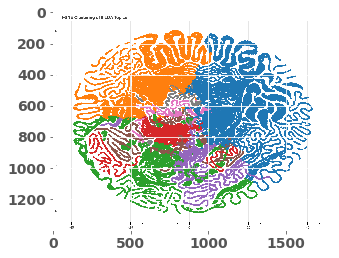

In [0]:
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['8_cluster.png']))

plt.imshow(im)
plt.show()

In [0]:
start_time = datetime.now()
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model_8, corpus, dictionary=model_8.id2word)
end_time = datetime.now()
print('Duration: {}'.format(end_time -start_time))
pyLDAvis.save_html(vis, '/content/drive/My Drive/capstone3/8_topmodelling.html')
vis

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Duration: 0:52:10.566577


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.165282 -0.091527  1       1        21.478954
1      0.035196  0.073151  2       1        14.279699
2      0.062812  0.033807  3       1        13.736332
7      0.225108  0.128239  4       1        13.556301
4     -0.024415  0.076927  5       1        12.560217
5     -0.041547 -0.202293  6       1        12.086387
6     -0.125449 -0.177224  7       1        6.366471 
3     -0.296987  0.158920  8       1        5.935645 , topic_info=    Category          Freq     Term         Total  loglift  logprob
6    Default  79670.000000  coffee   79670.000000  30.0000  30.0000
105  Default  58476.000000  tea      58476.000000  29.0000  29.0000
11   Default  48175.000000  dog      48175.000000  28.0000  28.0000
66   Default  63760.000000  food     63760.000000  27.0000  27.0000
38   Default  34725.000000  amazon   34725.000000  26.0000  26.0000
..       ...           ...     ...            ...      ...      ...
118  Topic8   2234.003418   milk     13957.775391  0.9920  -4.7246 
163  Topic8   2522.679932   use      20571.615234  0.7256  -4.6031 
256  Topic8   1480.748535   vanilla  7767.344727   1.1668  -5.1359 
106  Topic8   1267.916382   bit      19587.046875  0.0867  -5.2911 
172  Topic8   1154.316772   recipe   5751.042480   1.2183  -5.3849 

[551 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
261   3      0.057306  allergy
261   4      0.723674  allergy
261   5      0.218939  allergy
711   1      0.084520  almond 
711   5      0.915272  almond 
...  ..           ...     ... 
1069  8      0.999461  yeast  
5995  7      0.998015  yogi   
1050  5      0.867175  yogurt 
1050  8      0.132680  yogurt 
3178  3      0.998239  zico   

[941 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 8, 5, 6, 7, 4])

In [0]:
start_time = datetime.now()

# Clustering 9
model_9 = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=9,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
# save the model
model_9.save('/content/drive/My Drive/capstone3/model_9.model')
end_time = datetime.now()
print('Duration: {}'.format(end_time -start_time))
df_9 = pd.DataFrame(model_9.print_topics(-1))
df_9

Duration: 0:09:47.461928


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,0,1
0,0,"0.040*""amazon"" + 0.035*""price"" + 0.031*""store"" + 0.026*""box"" + 0.020*""bag"" + 0.018*""time"" + 0.018*""order"" + 0.013*""love"" + 0.012*""item"" + 0.012*""package"""
1,1,"0.034*""flavor"" + 0.022*""chip"" + 0.021*""taste"" + 0.020*""sauce"" + 0.020*""salt"" + 0.011*""rice"" + 0.011*""bag"" + 0.010*""food"" + 0.010*""cheese"" + 0.010*""love"""
2,2,"0.035*""water"" + 0.019*""bottle"" + 0.017*""day"" + 0.016*""coconut"" + 0.015*""taste"" + 0.013*""time"" + 0.013*""baby"" + 0.013*""oil"" + 0.010*""food"" + 0.009*""use"""
3,3,"0.056*""chocolate"" + 0.054*""flavor"" + 0.032*""milk"" + 0.030*""taste"" + 0.029*""mix"" + 0.019*""vanilla"" + 0.018*""water"" + 0.018*""drink"" + 0.016*""powder"" + 0.013*""juice"""
4,4,"0.038*""bar"" + 0.033*""sugar"" + 0.030*""taste"" + 0.028*""snack"" + 0.025*""flavor"" + 0.020*""calorie"" + 0.019*""cereal"" + 0.017*""protein"" + 0.015*""ingredient"" + 0.015*""cookie"""
5,5,"0.162*""coffee"" + 0.048*""cup"" + 0.029*""flavor"" + 0.022*""taste"" + 0.021*""kcup"" + 0.013*""pod"" + 0.013*""blend"" + 0.011*""roast"" + 0.011*""bean"" + 0.010*""love"""
6,6,"0.228*""tea"" + 0.037*""flavor"" + 0.029*""taste"" + 0.022*""bag"" + 0.018*""honey"" + 0.016*""ginger"" + 0.016*""love"" + 0.015*""cup"" + 0.010*""drink"" + 0.009*""time"""
7,7,"0.089*""food"" + 0.087*""dog"" + 0.045*""cat"" + 0.040*""treat"" + 0.011*""time"" + 0.011*""chicken"" + 0.011*""year"" + 0.010*""ingredient"" + 0.010*""day"" + 0.009*""love"""
8,8,"0.057*""hair"" + 0.029*""gum"" + 0.022*""skin"" + 0.020*""shampoo"" + 0.019*""chew"" + 0.018*""tooth"" + 0.014*""conditioner"" + 0.013*""breath"" + 0.013*""oil"" + 0.012*""use"""
